# BHP calculation using psapy library with Volve well and actual BHP comparison

In [57]:
import welly
from bs4 import BeautifulSoup
import pandas as pd
import psapy.BeggsandBrill as BB
import credentials
import sqlalchemy as db
import matplotlib.pyplot as plt
import numpy as np

In [2]:
WITSML_file = r"M:\Volve\WITSML Realtime drilling data\Norway-Statoil-NO 15_$47$_9-F-15\2\trajectory\1.xml"

In [60]:
with open(WITSML_file) as f:
    data = f.read()
data_xml = BeautifulSoup(data, 'xml')

In [61]:
columns = ['azi', 'md', 'tvd', 'incl', 'dispNs', 'dispEw']
df = pd.DataFrame()
for col in columns:
    df[col] = [float(x.text) for x in data_xml.find_all(col)]

In [62]:
df['well'] = '9-F-15'

In [63]:
df

,azi,md,tvd,incl,dispNs,dispEw,well
0,0.00,0.0000,0.0000,0.00,-3.1700,3.5300,9-F-15
1,0.00,145.9000,145.9000,0.00,-3.1700,3.5300,9-F-15
2,253.69,153.4000,153.4000,0.15,-3.1728,3.5206,9-F-15
3,146.02,234.2000,234.1996,0.28,-3.3662,3.5294,9-F-15
4,136.21,274.6000,274.5978,0.78,-3.6465,3.7749,9-F-15
...,...,...,...,...,...,...,...
109,107.51,4524.2000,3185.9439,77.65,201.7164,1449.4273,9-F-15
110,107.84,4564.9000,3193.8139,80.05,189.5929,1487.4710,9-F-15
111,108.48,4605.4030,3200.1182,82.04,177.1232,1525.4852,9-F-15
112,108.37,4645.7049,3205.6993,82.04,164.5080,1563.3527,9-F-15


In [64]:
## Initial well info
gas_grav = 0.65
oil_grav = 35
wtr_grav = 1.07
diameter=3.5
tht=100.0
twf=150.0
depth =5000

In [65]:
def temp_gradient(t0,t1, depth):
    if depth==0:
        return 0
    else:
        return abs(t0-t1)/depth    

t_grad = temp_gradient(tht,twf, depth)

In [66]:
t_grad

0.01

In [67]:
depths = df['tvd']*3.28084
temps = tht + t_grad*depths
inclination = [abs(90-x) for x in df['incl']]
tvd_max = max(df['tvd'])

In [68]:
temps

0      100.000000
1      104.786746
2      105.032809
3      107.683714
4      109.009114
          ...    
109    204.525722
110    204.783924
111    204.990758
112    205.173865
113    205.307116
Name: tvd, Length: 114, dtype: float64

In [69]:
def pressure_traverse(oil_rate, thp, water_rate, gor, angle):
    p=[]
    dpdz=[]
    for i in range(len(depths)):

        if i==0:
            p.append(thp)
        else:
            dz = (depths[i]-depths[i-1])
            pressure = p[i-1]+dz*dpdz[i-1]
            p.append(pressure)

        dpdz_step = BB.Pgrad(p[i], temps[i], oil_rate, water_rate, gor, gas_grav, oil_grav, wtr_grav, diameter, angle[i]) 
        dpdz.append(dpdz_step)
        
    return p, dpdz

p, dpdz = pressure_traverse(5000, 100, 500, 300, inclination)

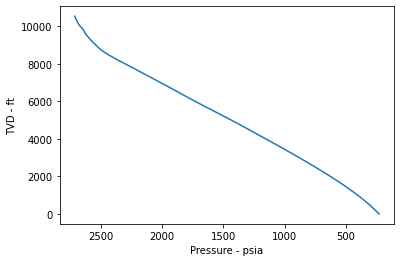

In [82]:
plt.plot(p, depths)
plt.xlabel('Pressure - psia')
plt.ylabel('TVD - ft')
plt.gca().invert_xaxis()

In [71]:
p[-1]/14.5038

193.4291240734265

### Bring the BHP from the database

In [72]:
## Create the connection to my DB
user = credentials.user
password = credentials.password
db_name = 'Volve_PEG'
sql_flavour = 'postgresql+psycopg2://'
engine_string = sql_flavour + user + ":" + password + "@localhost:5432/" + db_name
engine = db.create_engine(engine_string)
connection = engine.connect()

In [73]:
def CustomQuery(table, quantities, well):
    query = "SELECT dates, " + quantities + " FROM " + table + \
    ' WHERE well like ' + "'%%" + well + "%%'"
    df_temp = pd.read_sql(query, con=engine)
    return df_temp

In [74]:
df_prod = CustomQuery('production', ' bhp, oilvol, watervol, gasvol, thp ', '15/9-F-15')
df_prod

,dates,bhp,oilvol,watervol,gasvol,thp
0,2014-01-12,303.747100,0.00,0.0,0.0,20.212240
1,2014-01-13,303.955410,0.00,0.0,0.0,23.260360
2,2014-01-14,303.377050,0.00,0.0,0.0,21.347140
3,2014-01-15,304.405040,0.00,0.0,0.0,31.875490
4,2014-01-16,241.770858,351.05,0.0,52394.9,55.870746
...,...,...,...,...,...,...
973,2016-09-13,345.906770,0.00,0.0,0.0,0.000000
974,2016-09-14,345.906770,0.00,0.0,0.0,0.000000
975,2016-09-15,345.906770,0.00,0.0,0.0,0.000000
976,2016-09-16,345.906770,0.00,0.0,0.0,0.000000


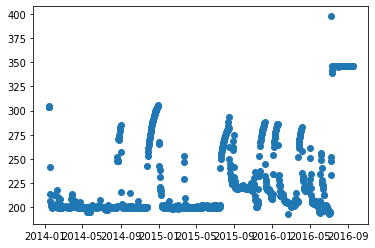

In [75]:
plt.scatter(df_prod['dates'], df_prod['bhp'])

In [76]:
bhp_calculated =[]
for i in range(len(df_prod['dates'])):
    oil = df_prod.iloc[[i]]['oilvol']*6.28981
    water = df_prod.iloc[[i]]['watervol']*6.28981
    gas = df_prod.iloc[[i]]['gasvol']*35.315
    thp = df_prod.iloc[[i]]['thp']*14.5038
    oil = oil.values[0]
    gas = gas.values[0]
    water = water.values[0]
    thp = thp.values[0]
    gor = gas/oil
    if oil == 0.0:     
        bhp_calculated.append(0)
    else:
        p, dpdz = pressure_traverse(oil, thp, water, gor, inclination)
        bhp_calculated.append(p[-1]/14.5)

c:\users\prime\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


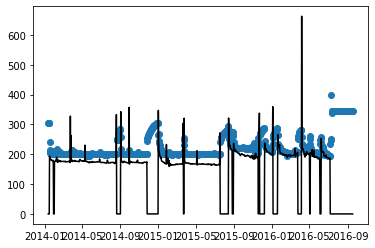

In [78]:
#bhp_calculated_dummy = np.array(bhp_calculated) + 100
plt.scatter(df_prod['dates'], df_prod['bhp'])
plt.plot(df_prod['dates'], bhp_calculated, color='black')